In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

https://github.com/bradsun91/alpha-scientist/blob/master/content/03_Feature_Selection.ipynb

# Introduction

This is the third post in my series on transforming data into alpha. If you haven't yet see the data management and guide to feature engineering, please take a minute to read those first...

This post is going to delve into the mechanics of feature selection to help choose between the many variations of features created in the feature engineering stage. If you'd like to replicate and experiment with the below code, you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"

By design, many of the features you've created will be very similar to each other (aka "collinear") because you've derived them from the same underlying dataset. If we were to keep many highly collinear features in our dataset used to train models, it would likely cause the model to "learn" some very funky and dangerous patterns. I will discuss this in greater depth in a future post.

The goal of feature selection is to reduce our possible features into the best set of features to learn from data. This will lead to models which generalize better (i.e., work well on data they haven't seen). They will also be much more interpretable.

# Philosophy

In feature selection, we strive to meet two goals:

- Strength: Choose the features with the strongest, most persistent relationships to the target outcome variable. The reasons for this are obvious.
- Orthogonality: Minimize the amount of overlap or collinearity in your selected features. The importance of orthogonality (non-overlap) of features is much greater than you might guess.

I am biased towards making feature selection a relatively mechanical process. The "art" should mainly be encapsulated within the prior step (feature engineering) and the subsequent step (modeling).

Feature selection should, in my view, follow a heuristic and can be encoded into an algorithm if desired. For purposes of this tutorial, I'll keep things relatively manual.

# Get data

In [4]:
location = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/" 
j = "j9000_d.csv"
jm = "jm000_d.csv"

In [5]:
j_df = pd.read_csv(location+j, engine="python", header=None)
jm_df = pd.read_csv(location+jm, engine='python', header=None)
j_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'holdings']
jm_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'holdings']

jm_df_cols = jm_df[['date', 'open', 'high', 'low', 'close', 'volume']]
j_df_cols = j_df[['date', 'open', 'high', 'low', 'close', 'volume']]

jm_df_cols['symbol'] = 'jm'
j_df_cols['symbol'] = 'j'

jm_df_cols['date'] = pd.to_datetime(jm_df_cols['date'])
j_df_cols['date'] = pd.to_datetime(j_df_cols['date'])

jm_df_cols = jm_df_cols.set_index(['date','symbol'])
j_df_cols = j_df_cols.set_index(['date', 'symbol'])

prices = pd.concat([jm_df_cols, j_df_cols]).sort_index()

In [6]:
prices.head()

,,open,high,low,close,volume
date,symbol,,,,,
2011-04-15,j,2275.0,2285.0,2228.0,2250.0,58080
2011-04-18,j,2239.0,2389.0,2237.0,2382.0,133636
2011-04-19,j,2371.0,2385.0,2321.0,2337.0,205268
2011-04-20,j,2353.0,2396.0,2329.0,2344.0,176032
2011-04-21,j,2359.0,2364.0,2324.0,2336.0,97806


# Create real prices returns as outcomes

In [9]:
outcomes = pd.DataFrame(index=prices.index)
# next hour's opening change
outcomes['close_1'] = prices.groupby(level='symbol').close.pct_change(-1) # next hour's returns
outcomes['close_5'] = prices.groupby(level='symbol').close.pct_change(-5) # next five hours' returns
outcomes['close_10'] = prices.groupby(level='symbol').close.pct_change(-10) # next 10 hours' returns
outcomes['close_20'] = prices.groupby(level='symbol').close.pct_change(-20) # next 20 hours' (approx) returns

print(outcomes.tail())

                             close_1  close_5  close_10  close_20
date                symbol                                       
2018-12-13 11:00:00 jm     -0.385553      NaN       NaN       NaN
2018-12-13 13:00:00 j       0.623144      NaN       NaN       NaN
                    jm     -0.376750      NaN       NaN       NaN
2018-12-13 14:00:00 j       0.618042      NaN       NaN       NaN
                    jm           NaN      NaN       NaN       NaN


# Create the hypothetical factors that predicts the outcomes

Assume we have a target variable called outcome which can be (partially) predicted with three factors, factor_1, factor_2 and factor_3. There's also an unpredictble noise component.

We'll use numpy.random to graft dummy values mapped onto the indices of real price data.

In [10]:
num_obs = prices.close.count()
factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
outcome = 1.*factor_1 + 2.*factor_2 + 3.*factor_3 + 5.*np.random.randn(num_obs)
outcome.name = 'outcome'
outcome.tail()

date                 symbol
2018-12-13 11:00:00  jm       -0.181213
2018-12-13 13:00:00  j         6.059067
                     jm       -5.180131
2018-12-13 14:00:00  j        -8.835899
                     jm       -4.176061
Name: outcome, dtype: float64

# Create features having/not having interative effects with predicted factors

Now, we will engineer several variations on features which each contain some information about the three factors, plus a few which contain some interaction effects, and some which do not contain any useful data.

Note that we are, again, "cheating" here for illustration purposes.

In [13]:
features = pd.DataFrame(index=outcome.index)
features['f11'] = 0.2*factor_1 + 0.8*np.random.randn(num_obs)
features['f12'] = 0.4*factor_1 + 0.6*np.random.randn(num_obs)
features['f13'] = 0.6*factor_1 + 0.4*np.random.randn(num_obs)

features['f21'] = 0.2*factor_2 + 0.8*np.random.randn(num_obs)
features['f22'] = 0.4*factor_2 + 0.8*np.random.randn(num_obs)
features['f23'] = 0.6*factor_2 + 0.4*np.random.randn(num_obs)

features['f31'] = 0.2*factor_3 + 0.8*np.random.randn(num_obs)
features['f32'] = 0.4*factor_3 + 0.6*np.random.randn(num_obs)
features['f33'] = 0.6*factor_3 + 0.4*np.random.randn(num_obs)

features['f41'] = 0.2*factor_1+0.2*factor_2 + 0.6*np.random.randn(num_obs)
features['f42'] = 0.2*factor_2+0.2*factor_3 + 0.6*np.random.randn(num_obs)
features['f43'] = 0.2*factor_3+0.2*factor_1 + 0.6*np.random.randn(num_obs)

features['f51'] = np.random.randn(num_obs)
features['f52'] = np.random.randn(num_obs)
features['f53'] = np.random.randn(num_obs)

print(features.tail())

                                 f11       f12       f13       f21       f22  \
date                symbol                                                     
2018-12-13 11:00:00 jm      0.573854 -0.088118 -0.804286  0.481749  1.993273   
2018-12-13 13:00:00 j      -0.342989 -0.255101  0.323753  0.745643 -0.081057   
                    jm     -1.126165 -1.015561 -0.633867  0.561081  2.339104   
2018-12-13 14:00:00 j      -0.231094  0.322454  0.123398 -0.509877 -0.125337   
                    jm     -1.133372  0.129529 -0.225342  1.242546 -0.498742   

                                 f23       f31       f32       f33       f41  \
date                symbol                                                     
2018-12-13 11:00:00 jm      1.413015  0.244674  0.142583 -1.026008  0.986983   
2018-12-13 13:00:00 j      -0.252317 -0.292088  0.947028  1.138424  0.745989   
                    jm      1.284650 -0.530322  0.529280  0.656967  0.109368   
2018-12-13 14:00:00 j      -0.467571  0

# Data Preparation to Standardize or Normalize Data

Before evaluating the features for predictive strength and orthogonality, we'll do a quick data preparation stage. It is sometimes vital to "standardize" or "normalize" data so that we get fair comparisons between features of differing scale. Strictly speaking, since all of the doctored outcome and feature data is already drawn from normal distribution (using the numpy function random.rnorm()) we don't really need this step, but good practice to include.

Here, I'll use the scikit-learn StandardScaler() method and some pandas magic to transform the data.

In [15]:
import seaborn as sns
from IPython.display import display
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler,Normalizer


#f = features.dropna() #optional - to compare apples to apples

############### The main step is, to use the StandardScaler class on the targeted dataset #################

# Step 1: standardize or normalize data 
std_scaler = StandardScaler()


features_scaled = std_scaler.fit_transform(features.dropna()) 


print (features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.tail()

# Step 2: standardize outcome as well 
outcome_df = outcome.to_frame()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
print(outcome_scaled.tail())

(23146, 15)
                             outcome
date                symbol          
2018-12-13 11:00:00 jm     -0.023404
2018-12-13 13:00:00 j       0.980788
                    jm     -0.827835
2018-12-13 14:00:00 j      -1.416124
                    jm     -0.666259


In [31]:
outcome_df.head()

,,outcome
date,symbol,
2011-04-15 09:00:00,j,4.301527
2011-04-15 10:00:00,j,-4.273124
2011-04-15 11:00:00,j,0.224061
2011-04-15 13:00:00,j,-0.450768
2011-04-15 14:00:00,j,10.473177


In [30]:
outcome_scaled.head()

,,outcome
date,symbol,
2011-04-15 09:00:00,j,0.697963
2011-04-15 10:00:00,j,-0.681878
2011-04-15 11:00:00,j,0.041813
2011-04-15 13:00:00,j,-0.066781
2011-04-15 14:00:00,j,1.691111


In [37]:
outcome.head()

date                 symbol
2011-04-15 09:00:00  j          4.301527
2011-04-15 10:00:00  j         -4.273124
2011-04-15 11:00:00  j          0.224061
2011-04-15 13:00:00  j         -0.450768
2011-04-15 14:00:00  j         10.473177
Name: outcome, dtype: float64

In [36]:
outcome.shift(-1).head()

date                 symbol
2011-04-15 09:00:00  j         -4.273124
2011-04-15 10:00:00  j          0.224061
2011-04-15 11:00:00  j         -0.450768
2011-04-15 13:00:00  j         10.473177
2011-04-15 14:00:00  j         13.560442
Name: outcome, dtype: float64

# Dive into the insights of the strength of correlation

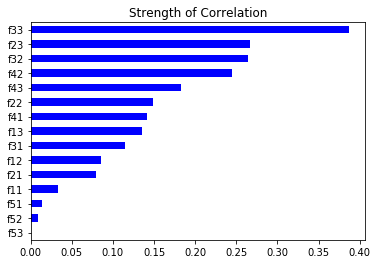

In [32]:
# This is the correlation NOT USING shift(-1) on the outcome results
corr = df.corrwith(outcome)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

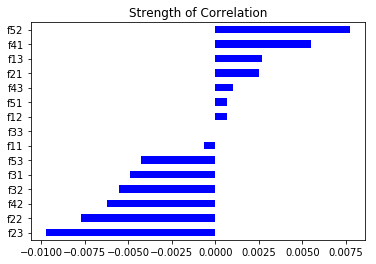

In [38]:
# This is the correlation USING shift(-1) on the outcome results
# As we can see, this reflects the real correlation analysis results, which drops in correlation values when we 
# try to use the current timestamp's feature to predict the next timestamp's outcome for trading's purpose.
corr = df.corrwith(outcome.shift(-1))
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

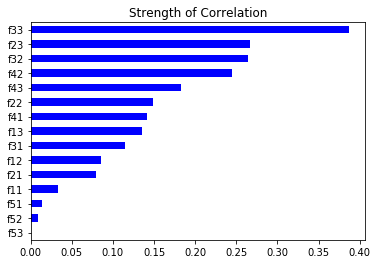

In [70]:
# But anyway, let's get back to the example's variable assignment:

# This is the correlation NOT USING shift(-1) on the outcome results
corr = df.corrwith(outcome)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

# Test Orthogonality

Pretend for a minute that we don't know which features are going to be stronger and weaker, and which are going to tend to cluster together. We've got an idea that there are some quite strong features, some weaker, and some useless.

While correlation is not the perfect metric, it gives us a reasonable sense of strength of each feature's historical relationship to the outcome variable.

However, it says nothing about orthogonality. To get an idea about this, we'll take advantage of the very handy seaborn clustermap chart type which plots a heatmap representation of a covariance matrix and runs a hierarchical clustering algorithm to group together the most closely related features.

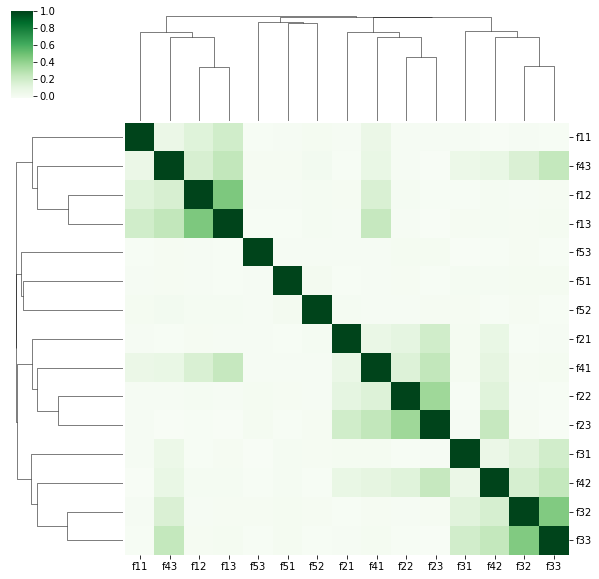

In [58]:
corr_matrix = df.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(10,10),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

The algorithm has done a good job of finding the groupings of features. Of course, the diagonal of dark green represents each feature being perfectly correlated with itself, but we also see certain clusters of features which are similar to one another.

The cluster in the upper left captures factor_1 (including some of the interaction effects). factor_3 is fairly well isolated in the lower right corner, and in the middle we can see factor_2 as well as some of the noise features.

Let's next focus in only on those features with correlations of greater than 0.1 to exclude the noise and weak features.

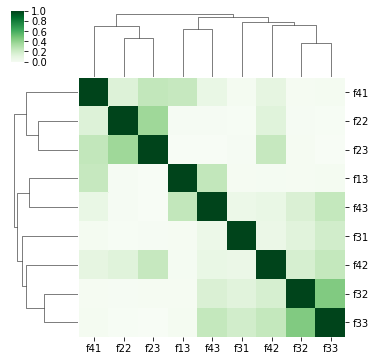

Correlation Strength:
f33    0.387426
f23    0.266334
f32    0.263710
f42    0.245308
f43    0.183144
f22    0.148517
f41    0.141258
f13    0.135588
f31    0.114610
dtype: float64


In [72]:
correlated_features = corr[corr>0.1].index.tolist()
corr_matrix = df[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr[corr>0.1].sort_values(ascending=False))

# Seclect Features

Ah, now the clusters look a bit sharper. We'll follow a simple heuristic to manually select the features.

- Step 1: Take the most strongly correlated feature (f33) and add it to our list of selected features. 

- Step 2: Take the second correlated feature (f23) and check to see if it's closely correlated (neighboring in the clustermap) to any features already chosen. If no, add to the list. If yes, discard. 

- Step 3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.

Those interested could encode this heuristic into an algorithm without too much difficulty.

Following this heuristic, I get the below features:

/Users/miaoyuesun/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


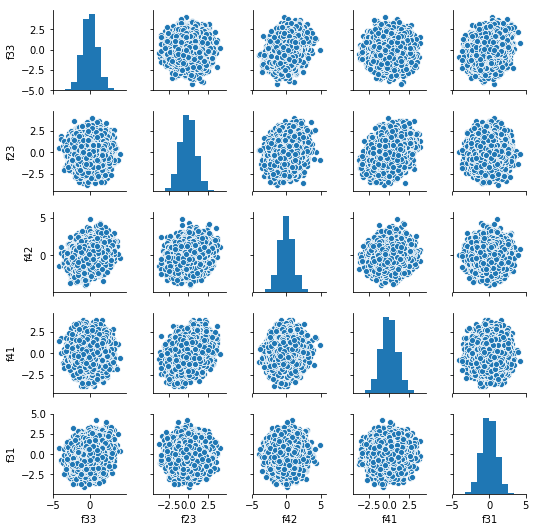

In [73]:
selected_features = ['f33','f23','f42','f41','f31']
import seaborn as sns
sns.pairplot(df[selected_features],size=1.5)

Note that this list of features is not simply the highest correlated features. Let's run the clustermap one more time to see if we've missed any major clusters.

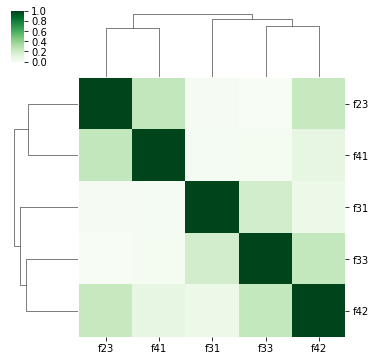

In [74]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

# Check stationarity of correlations

Looks generally pretty good. There is some residual covariance between features, so we haven't achieved orthogonal nirvana, but we're pretty close.

Thus far, we've only used a simple correlation statistic across the full time period. This is a good place to start but, in my opinion, is a dangerous place to stop. Financial time series data suffers from non-stationarity and regime change, so a relationship which on average has existed may have been wildly unstable over time.

To check, we'll plot the rolling correlation of these selected features.

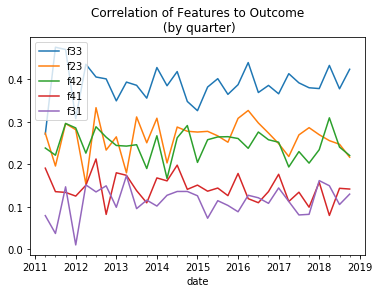

In [75]:
tmp = df[selected_features].join(outcome_scaled).reset_index().set_index('date')
tmp.dropna().resample('Q').apply(lambda x: x.corr()).iloc[:,-1].unstack()\
.iloc[:,:-1].plot(title='Correlation of Features to Outcome\n (by quarter)')
# shows time stability

As expected, since the data wasn't modeled with any non-stationarity, our features all appear to be robust over time. This gives increased confidence that the relationship we've found is likely to persist.

# Summary

This installment of the tutorial series has walked through a systematic approach for selecting a subset of features from a universe of many overlapping (collinear) features. At this point, we're ready to model!

In the next post, I'll walk through an approach for training models in a "walk forward" basis - highly useful when working with ordered (e.g., time series) datasets.